# Epoching Trials and Attaching Behavioral Metadata

Here, just demonstrate the usage of getting the Epochs of trials into a 
usable form.

In [1]:
# auto-format every cell to black
%load_ext lab_black

In [107]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import sys

import mne
from mne import read_epochs
from mne.io import read_raw_fif
from mne_bids import BIDSPath, read_raw_bids

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../../")
from mtsmorf.io.move.read import (
    read_move_trial_epochs,
    read_behav_xy_coords,
    read_trial_metadata,
    _get_bad_epochs,
    compute_xy_metrics,
)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
root = "/Users/adam2392/OneDrive - Johns Hopkins/efri"

subject = "efri07"

# Read Behavioral Physio XY coordiantes

In [4]:
xy_raw = read_behav_xy_coords(root, subject)
print(xy_raw)

Creating RawArray with float64 data, n_channels=2, n_times=2614000
    Range : 0 ... 2613999 =      0.000 ...  1306.999 secs
Ready.
Reading events from /Users/adam2392/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
<RawArray | sub-efri07_ses-efri_task-move_acq-seeg_run-01_rec-xy_physio.tsv.gz, 2 x 2614000 (1307.0 s), ~39.9 MB, data loaded>


In [5]:
print(xy_raw.filenames)

(BIDSPath(
root: /Users/adam2392/OneDrive - Johns Hopkins/efri
datatype: ieeg
basename: sub-efri07_ses-efri_task-move_acq-seeg_run-01_rec-xy_physio.tsv.gz),)


In [39]:
event_key_start = "Go Cue"
event_key_end = "Hit Target"

In [7]:
metrics_df = compute_xy_metrics(xy_raw, event_key_start, event_key_end)

display(metrics_df.head())

Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']


channel,x,y,Time,Dist,Speed,trial_idx,trial_duration
time,,,,,,,
83632,NaN,NaN,NaN,NaN,NaN,1,1.303
83633,97656.25,0.00,1.0,97656.2500,48.828125,1,1.303
83634,97656.25,97656.25,1.0,138106.7932,69.053397,1,1.303
83634,97656.25,97656.25,0.0,138106.7932,NaN,1,1.303
83634,0.00,0.00,0.0,0.0000,NaN,1,1.303


<AxesSubplot:xlabel='trial_idx', ylabel='nanmean'>

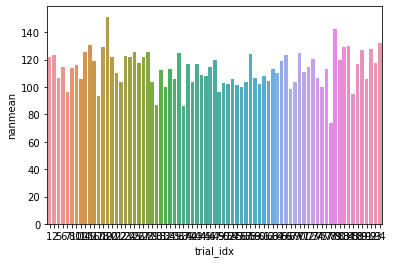

In [8]:
summ_df = metrics_df.groupby("trial_idx")["Speed"].agg([np.nanmean, np.nanstd])
summ_df.reset_index(inplace=True)
sns.barplot(x="trial_idx", y="nanmean", data=summ_df)

In [9]:
print(xy_raw.info)
print(xy_raw.get_data()[:, :5])

<Info | 7 non-empty values
 bads: []
 ch_names: x, y
 chs: 2 BIO
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 2
 projs: []
 sfreq: 2000.0 Hz
>
[[ 28.90625   28.90625   28.90625   28.90625   28.90625 ]
 [244.140625 244.140625 244.140625 244.140625 244.140625]]


In [10]:
# read behavioral dataframe
# BIDS Path entities
session = "efri"
task = "move"
acquisition = "seeg"
datatype = "ieeg"
extension = ".vhdr"
run = "01"  # default run (only one per task)

bids_path = BIDSPath(
    subject=subject,
    session=session,
    task=task,
    acquisition=acquisition,
    datatype=datatype,
    run=run,
    suffix=datatype,
    extension=extension,
    root=root,
)

behav_path = bids_path.copy().update(suffix="behav", extension=".tsv")

behav_df = pd.read_csv(behav_path, delimiter="\t", index_col=None)

display(behav_df.head())

,trial_id,successful_trial_flag,reaction_time,n_reaction_time,r_reaction_time,missed_target_flag,speed_instruction,speed_ratio,correct_speed_flag,force_angular,force_magnitude,target_direction,x_position,y_position
0,1,0,NaN,NaN,NaN,0,0.333333,1.000000,0,0.000000,0.000000,2,[0.0000000e+00 1.2246468e-16],[0. 2.]
1,2,1,0.7965,-0.699108,0.145833,0,0.333333,0.621152,0,0.000000,0.000000,0,[ 0.0000000e+00 -3.6739404e-16],[ 0. -2.]
2,3,1,0.7825,-0.753172,0.104167,0,0.333333,0.758682,0,0.000000,0.000000,1,[0. 2.],[0. 0.]
3,4,1,1.1220,0.557875,0.864583,0,0.666667,0.682315,1,0.000000,0.000000,2,[0.0000000e+00 1.2246468e-16],[0. 2.]
4,5,1,0.9900,0.048130,0.687500,0,0.666667,0.854296,0,4.707314,11.178812,0,[ 0.0000000e+00 -3.6739404e-16],[ 0. -2.]


In [33]:
trials = read_trial_metadata(root, subject)

In [34]:
trial = trials[0]
trial_df = trial.to_data_frame()
print(len(trial_df))
display(trial_df.head())

1


,index,subject,perturbed,fixation_trial,target_direction,success,reaction_time,correct_speed,speed_instruction,beh_fname,event_fname,start_trial_id,end_trial_id,trial_duration,avg_speed,std_speed
1,0,efri07,False,False,2,False,NaN,0,slow,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,None,None,None,None,None


## Read Epochs and Illustrate Attached Metadata

In [101]:
%%time
epochs = read_move_trial_epochs(root=root, subject=subject)

Analyzing bids dataset: /Users/adam2392/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr with tmin=-0.2 and tmax=0.5 time-locked to Left Target.
Loaded in behavioral df: Index(['trial_id', 'successful_trial_flag', 'reaction_time', 'n_reaction_time',
       'r_reaction_time', 'missed_target_flag', 'speed_instruction',
       'speed_ratio', 'correct_speed_flag', 'force_angular', 'force_magnitude',
       'target_direction', 'x_position', 'y_position'],
      dtype='object')
Extracting parameters from /Users/adam2392/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/adam2392/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Users/adam2392/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task

../../mtsmorf/io/move/read.py:488: RuntimeWarning: Did not find any electrodes.tsv associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/efri/sub-efri07/**/sub-efri07_ses-efri*electrodes.tsv"
  # apply preprocessing to obtain Epochs
../../mtsmorf/io/move/read.py:488: RuntimeWarning: Did not find any coordsystem.json associated with sub-efri07_ses-efri_task-move_acq-seeg_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/efri/sub-efri07/**/sub-efri07_ses-efri*coordsystem.json"
  # apply preprocessing to obtain Epochs


Reading events from /Users/adam2392/OneDrive - Johns Hopkins/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Used Annotations descriptions: ['At Center', 'False Start', 'Go Cue', 'Held Target', 'Hit Target', 'Left Target', 'Reserved (End Trial)', 'Reserved (Start Trial)', 'Reward', 'Show Center', 'Speed Fail', 'Speed Feedback', 'Speed Instruction']
Adding metadata with 16 columns
Replacing existing metadata with 16 columns
96 matching events found
No baseline correction applied
0 projection items activated
new dropped indices [3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 51, 53, 68, 76, 81, 82, 86, 87, 90, 95]
Loading data for 96 events and 1401 original time points ...
0 bad epochs dropped
Dropped 20 epochs: 3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 51, 53, 68, 76, 81, 82, 86, 87, 90, 95
Setting up band-pass filter from 1 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

../../mtsmorf/io/move/utils.py:17: RuntimeWarning: filter_length (6601) is longer than the signal (1401), distortion is likely. Reduce filter length or filter a longer signal.
  new_epochs = epochs.filter(l_freq=l_freq, h_freq=h_freq)


CPU times: user 18.3 s, sys: 3.57 s, total: 21.8 s
Wall time: 22.1 s


In [91]:
print(epochs.event_id)
# print(epochs.metadata)
print(epochs.info)
print(len(epochs))
print(len(epochs.events))

{'Left Target': 10006}
<Info | 9 non-empty values
 bads: []
 ch_names: G8, G7, G3, G2, G1, V8, V7, V6, V4, V3, V2, V1, D9, D8, D3, D2, ...
 chs: 75 SEEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 line_freq: 60.0
 lowpass: 999.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 75
 projs: []
 sfreq: 2000.0 Hz
 subject_info: 4 items (dict)
>
76
76


# Note Number of Trials Dropped

In [102]:
print(epochs.get_data().shape)

(76, 75, 1401)


In [104]:
drop_inds = _get_bad_epochs(
    behav_df=behav_df, remove_perturbed=True, remove_unsuccessful=True
)
print(len(drop_inds))
print(len(behav_df) - len(drop_inds))

22
76


In [94]:
display(epochs.metadata.head())

,trial_idx,subject,perturbed,fixation_trial,target_direction,success,reaction_time,correct_speed,speed_instruction,beh_fname,event_fname,start_trial_id,end_trial_id,trial_duration,avg_speed,std_speed
0,1,efri07,False,False,0,True,0.7965,0,slow,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,Left Target,Hit Target,0.5065,171.624,148.226
1,2,efri07,False,False,1,True,0.7825,0,slow,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,Left Target,Hit Target,0.414,189.329,154.774
2,3,efri07,False,False,2,True,1.122,1,fast,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,Left Target,Hit Target,0.46,172.774,160.796
5,6,efri07,False,False,0,True,0.8665,0,slow,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,Left Target,Hit Target,0.391,189.839,158.112
6,7,efri07,False,False,2,True,1.13,0,slow,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,/Users/adam2392/OneDrive - Johns Hopkins/efri/...,Left Target,Hit Target,0.5745,140.397,154.104
